## Example Analysis of DLPFC 151673 with Spatial Enhancement
Here we provide an example analysis procedure for a single slide 10x Visium DLPFC data with spatial enhancement. The scource data could be downloaded from https://research.libd.org/spatialLIBD/ or using the R package **spatialLIBD**. The whole procedure is similar to the procedure introduced in the enhanced analysis of 10x Visium mouse olfactory bulb data.

In [1]:
import os
import sys
sys.path.append("../")
import scanpy as sc
import matplotlib.pyplot as plt
import STForte_v2.helper as stfhelper
from STForte_v2.helper import mclust_R
from STForte_v2.helper import save_gdata
from STForte_v2 import STGraph, STForteModel
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

trial_name = "trial-DLPFC-pca-151673"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]

Global seed set to 0


## Data preprocessing and generation
We perform simple preprocessing for the original data with the intention to remove empty count data. Then we generate the graph data format from the original anndata. (The preprocessing process is down by the default setting in STGraph)

In [2]:
adata = sc.read_h5ad('../data/DLPFC/151673_10xvisium.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialLIBD_colors'
    obsm: 'spatial'

In [3]:
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )
stgraph.pca()   # PCA uses default "full" svd solver to ensure the reproducing ability
stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
gdata = stgraph.topyg()
gdata

d-based initialize:   0%|          | 0/3639 [00:00<?, ?it/s]

PCA pre-compression for data, from 21842 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 25.29s.


brute-force knn initialize:   0%|          | 0/14201 [00:00<?, ?it/s]

Data(x=[14201, 300], xfp=[14201, 300], adj_t=[14201, 14201, nnz=255618], inv_dist=[255618], value_idx=[3639], infer_idx=[10562], coord=[14201, 2], x_id=[14201], mask_idx=[0])

## STForte Model
First, we establish model for DLPFC analysis with used anndata/graph data

In [4]:
model = STForteModel(adata=adata, gdata=gdata, epochs=450,
                     output_dir=f'./{trial_name}/pl_ckpts/',)
model.fit()

Global seed set to 42
/home/chunxuan/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_4ad4d2 | 71.9 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     To

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


## Save the model results

In [5]:
# save model and gdata
if not os.path.exists(f"{trial_name}/data"):
    os.makedirs(f"{trial_name}/data")
save_gdata(gdata, path=f"{trial_name}/data/gdata.pkl")
model.save_state_dict(f'./{trial_name}/models/', alias="STForteModel_DLPFC_151673")

In [6]:
# save adata of original resoltion
model.get_latent_original(adata)
if not os.path.exists(f"./{trial_name}/outputs"):
    os.makedirs(f"./{trial_name}/outputs")
adata.write(f"./{trial_name}/outputs/stforte.h5ad")
# save adata of enhanced resolution
adata_sp = model.get_result_anndata()
adata_sp.write_h5ad("./{:s}/outputs/sp.h5ad".format(trial_name))

## Load saved results

In [7]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata, adata_sp

(AnnData object with n_obs × n_vars = 3639 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'STForte_Mask'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'spatialLIBD_colors'
     obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'spatial',
 AnnData object with n_obs × n_vars = 14201 × 300
     obs: 'spot_instance'
     obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'spatial'
     obsp: 'A_STForte_conn', 'A_STForte_recon')

## Clustering results

In [8]:
n_clusters = 7
adata = mclust_R(adata, n_clusters, "mclust_STForte_ATTR", used_obsm="STForte_ATTR")
adata = mclust_R(adata, n_clusters, "mclust_STForte_TOPO", used_obsm="STForte_TOPO")
adata = mclust_R(adata, n_clusters, "mclust_STForte_COMB", used_obsm="STForte_COMB")

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.

/media/share/STForte/tutorials/../STForte_v2/helper/__cluster_helpers.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_add] = mclust_res
/media/share/STForte/tutorials/../STForte_v2/helper/__cluster_helpers.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_add] = mclust_res


/home/chunxuan/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


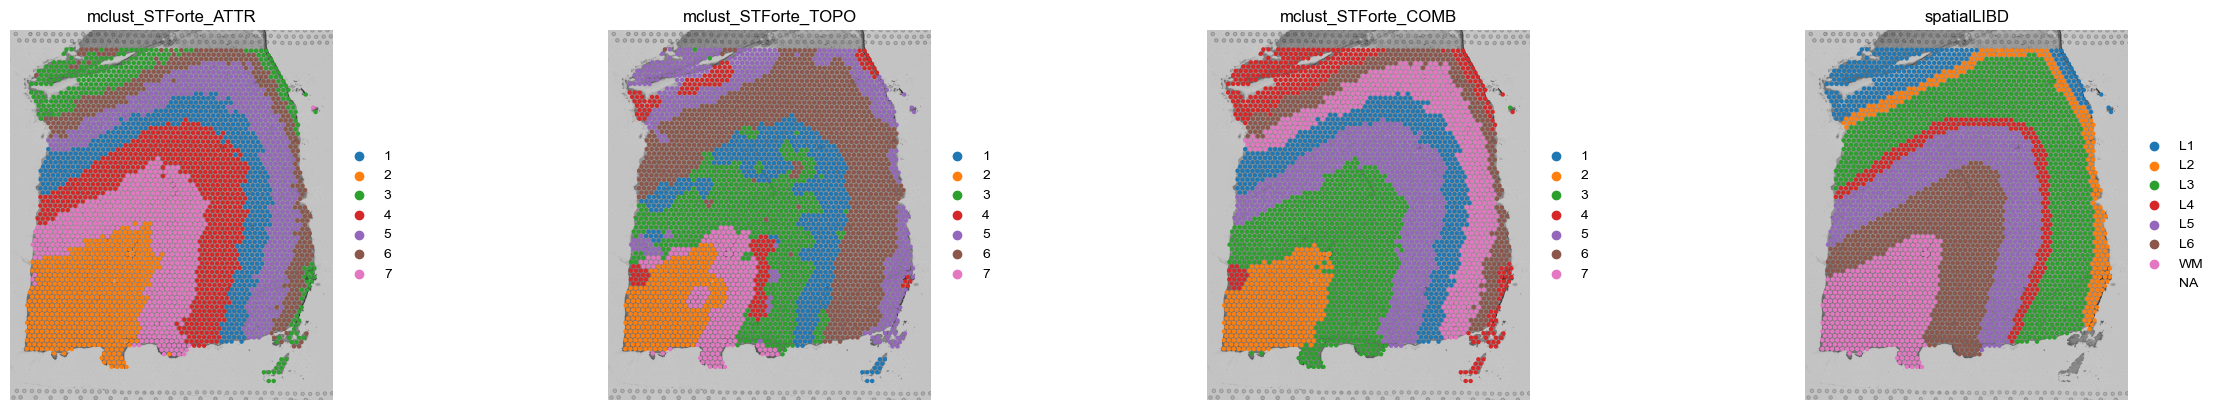

In [9]:
sc.pl.spatial(adata, color=["mclust_STForte_ATTR", "mclust_STForte_TOPO", "mclust_STForte_COMB", "spatialLIBD"], 
              img_key="hires", bw=True, size=1.25, frameon=False, save="_mclust_compare")

In [10]:
print("ARI_COMB:",ARI(adata.obs['mclust_STForte_COMB'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("NMI_COMB:",NMI(adata.obs['mclust_STForte_COMB'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("ARI_ATTR:",ARI(adata.obs['mclust_STForte_ATTR'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("NMI_ATTR:",NMI(adata.obs['mclust_STForte_ATTR'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("ARI_TOPO:",ARI(adata.obs['mclust_STForte_TOPO'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("NMI_TOPO:",NMI(adata.obs['mclust_STForte_TOPO'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))

ARI_COMB: 0.6072958762255776
NMI_COMB: 0.7086673922504615
ARI_ATTR: 0.6096687432227723
NMI_ATTR: 0.7125126756814102
ARI_TOPO: 0.5456214518488938
NMI_TOPO: 0.6007011713239889


In [11]:
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.pp.neighbors(adata, use_rep=f"{key}", key_added=f"STForte_{key}")
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    adata.obsm[f"X_{key}_umap"] = sc.tl.umap(adata, neighbors_key=f"STForte_{key}", copy=True).obsm['X_umap']

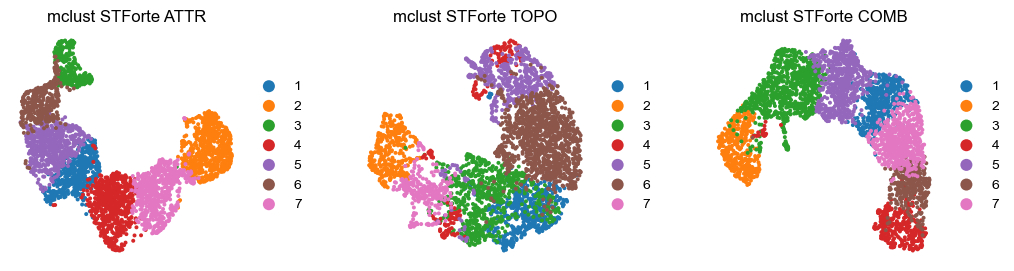

In [17]:
ncols, nrows = 3, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
i = 0
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.pl.scatter(adata, color=f"mclust_{key}", basis=f"{key}_umap", frameon=False, show=False, ax=axs[i])   
    i += 1

## Padding results

In [13]:
base_label = "STForte_COMB"
for key in ["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]:
    adata_sp.obs[f"mclust_{base_label}_pad_{key}"] = stfhelper.annotation_propagate(adata_sp, f"mclust_{base_label}", adata, latent_embed=key, copy=True)
    adata_sp.obs[f"mclust_{base_label}_pad_{key}"] = adata_sp.obs[f"mclust_{base_label}_pad_{key}"].astype('category')

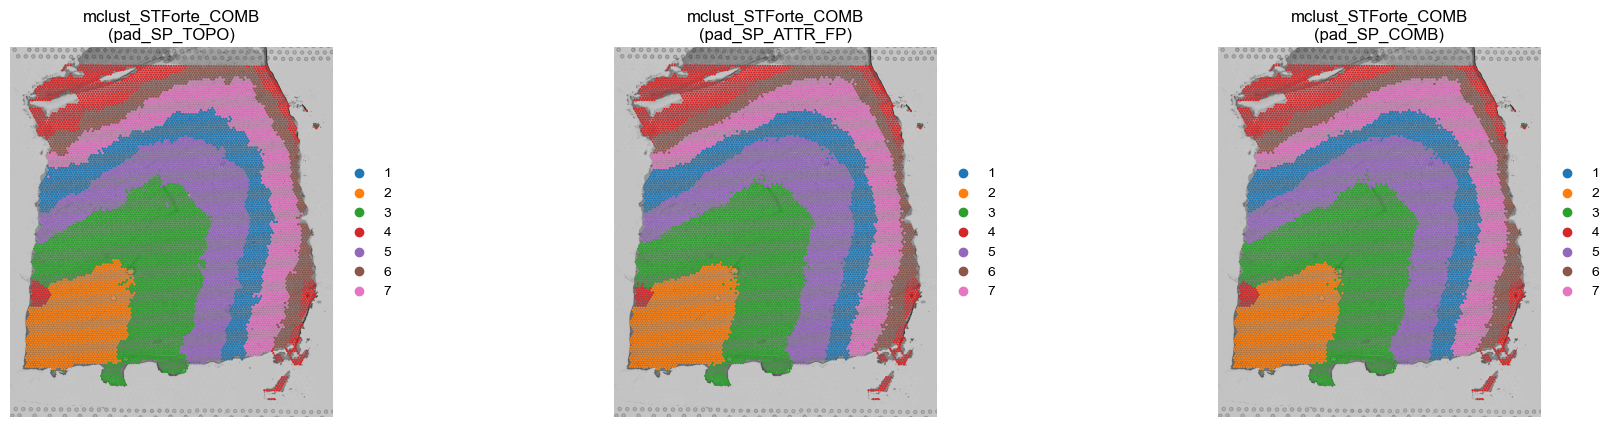

In [14]:
sc.pl.spatial(adata_sp, size=0.625, bw=True,
              color=[f'mclust_{base_label}_pad_SP_TOPO', f'mclust_{base_label}_pad_SP_ATTR_FP', f'mclust_{base_label}_pad_SP_COMB'], 
              title=[f'mclust_{base_label}\n(pad_SP_TOPO)', f'mclust_{base_label}\n(pad_SP_ATTR_FP)', f'mclust_{base_label}\n(pad_SP_COMB)'],
              frameon=False,
              img=adata.uns['spatial']['stomic']['images']['hires'],
              spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
              scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
              save="_mclust_sp_compare"
              )

In [15]:
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    sc.pp.neighbors(adata_sp, use_rep=f"{key}", key_added=f"CONN_{key}")
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    adata_sp.obsm[f"X_{key}_umap"] = sc.tl.umap(adata_sp, neighbors_key=f"CONN_{key}", copy=True).obsm['X_umap']

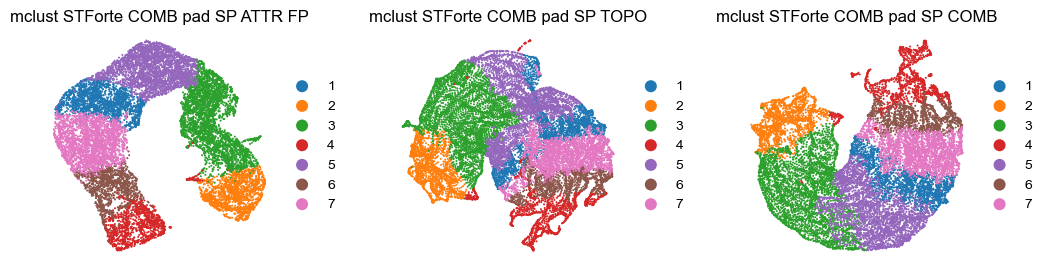

In [16]:
ncols, nrows = 3, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
i = 0
for key in  ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    sc.pl.scatter(adata_sp, color=f"mclust_STForte_COMB_pad_{key}", basis=f"{key}_umap", frameon=False, show=False, ax=axs[i])
    i += 1   